<a href="https://colab.research.google.com/github/dsliwka/EEMP2024/blob/main/Notebooks/EngagementPredSampleSolutions_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Job Engagement**
----

- We work with the LPP data to train algorithms to predict job engagement
- The first cell is given code that cleans the data and generates a DataFrame dfp that we use for the prediction
- It already standardizes the survey scales (here engagement and the Big5)

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats


## Read LPP Data
path_to_data = "https://raw.githubusercontent.com/dsliwka/EEMP2024/main/Data/LPP-CF_1215_v1.csv"
df = pd.read_csv(path_to_data)


## Keep only wave 2 (as here the LPP campus file has more information)
dfp=df[df.welle==2]

## Generate Engagement Scale
dfp=dfp.assign(enga=6-df.filter(regex="menga*").mean(axis=1))

## reverse health scale (as lower numbers represent better health in the survey)
dfp["mgesund_allg"]=6-dfp.mgesund_allg

## keep only rows where we have non-missing data on income, industry & engagement
dfp=dfp[dfp.meink_kateg.isnull()==False]
dfp=dfp[dfp.branche.isnull()==False]
dfp=dfp[dfp.enga.isnull()==False]

## Generate Big5 traits from items
dfp['conscientiousness']= (6-dfp.mbig_gruend +dfp.mbig_faul     + 6-dfp.mbig_effi)/3
dfp['extraversion']=      (6-dfp.mbig_komm   +dfp.mbig_zur      + 6-dfp.mbig_gesell)/3
dfp['neuroticism']=       (6-dfp.mbig_sorgen +dfp.mbig_entsp    + 6-dfp.mbig_nervoes)/3
dfp['openness']=          (6-dfp.mbig_origi	+6-dfp.mbig_kunst  + 6-dfp.mbig_phant  + 6-dfp.mbig_wissb)/4
dfp['agreeableness']=     (dfp.mbig_grob	    +6-dfp.mbig_verzeih+ 6-dfp.mbig_freundl)/3

## drop all rows in which either of the big5 traits are missing
dfp=dfp.dropna(subset=['conscientiousness', 'extraversion', 'neuroticism', 'openness', 'agreeableness'])

## Standardize all personality traits & engagement (i.e. substract the mean and divide by SD)
## Note: for simplicity we here use a function from package sciepy
dfp['conscientiousness'] = stats.zscore(dfp.conscientiousness)
dfp['extraversion'] = stats.zscore(dfp.extraversion)
dfp['neuroticism'] = stats.zscore(dfp.neuroticism)
dfp['openness'] = stats.zscore(dfp.openness)
dfp['agreeableness'] = stats.zscore(dfp.agreeableness)
dfp['enga'] = stats.zscore(dfp.enga)

## drop all columns with missing data:
dfp = dfp.dropna(axis=1)

## keep only subset of the variables
dfp=dfp[['enga','branche', 'ost', 'size',
       'bauswahl_interview', 'bauswahl_ac', 'bauswahl_kognit', 'bauswahl_pers',
       'bauswahl_arbeitsprobe', 'bauswahl_andere', 'bmagespr', 'bzv',
       'bentwplan', 'bbeurt', 'bvargehalt', 'bsonderz_nv', 'bmabefr',
       'bmabind_flexaz', 'bmabind_verg', 'bhomeoff', 'babsent_anz', 'msex',
       'alter', 'mstib', 'mleitung', 'maz_voll_teil', 'mheim', 'maz_freizeit',
       'mwb', 'mmagespr', 'mikt_nutz', 'mgesund_allg', 'mkind_anz_gr',
       'mkindu3','meink_kateg', 'conscientiousness','extraversion','neuroticism','openness','agreeableness']]

## As variable "brache" which contains the industry in which a person is working
## is categorial generate dummy variables for each industry
dfp =pd.get_dummies(dfp, columns=['branche'])

## inspect how many observations are remaining:
print("We have", dfp.shape[0], "observations and", dfp.shape[1], "variables.")


We have 886 observations and 44 variables.


Before we can train the different algorithms we have to specify the variable we want to predict (typically named y; here a Pandas series) and the feature matrix X (here we can just use a DataFrame that includes all variables except the variable we want to predict.


In [ ]:
## Assign the variable to be predicted
y = dfp.enga

## Assign the feature matrix (the predictors):
X=dfp.drop(columns='enga')



# **Decision Trees**
----

- We have to import the relevant packages
- We also here import pyplot to choose the size of the plotted tree


In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

dtree= DecisionTreeRegressor(max_depth=3).fit(X,y)
print("R²:", round(r2_score(y, dtree.predict(X)),3))

R²: 0.11


We can plot the tree to understand the prediction.

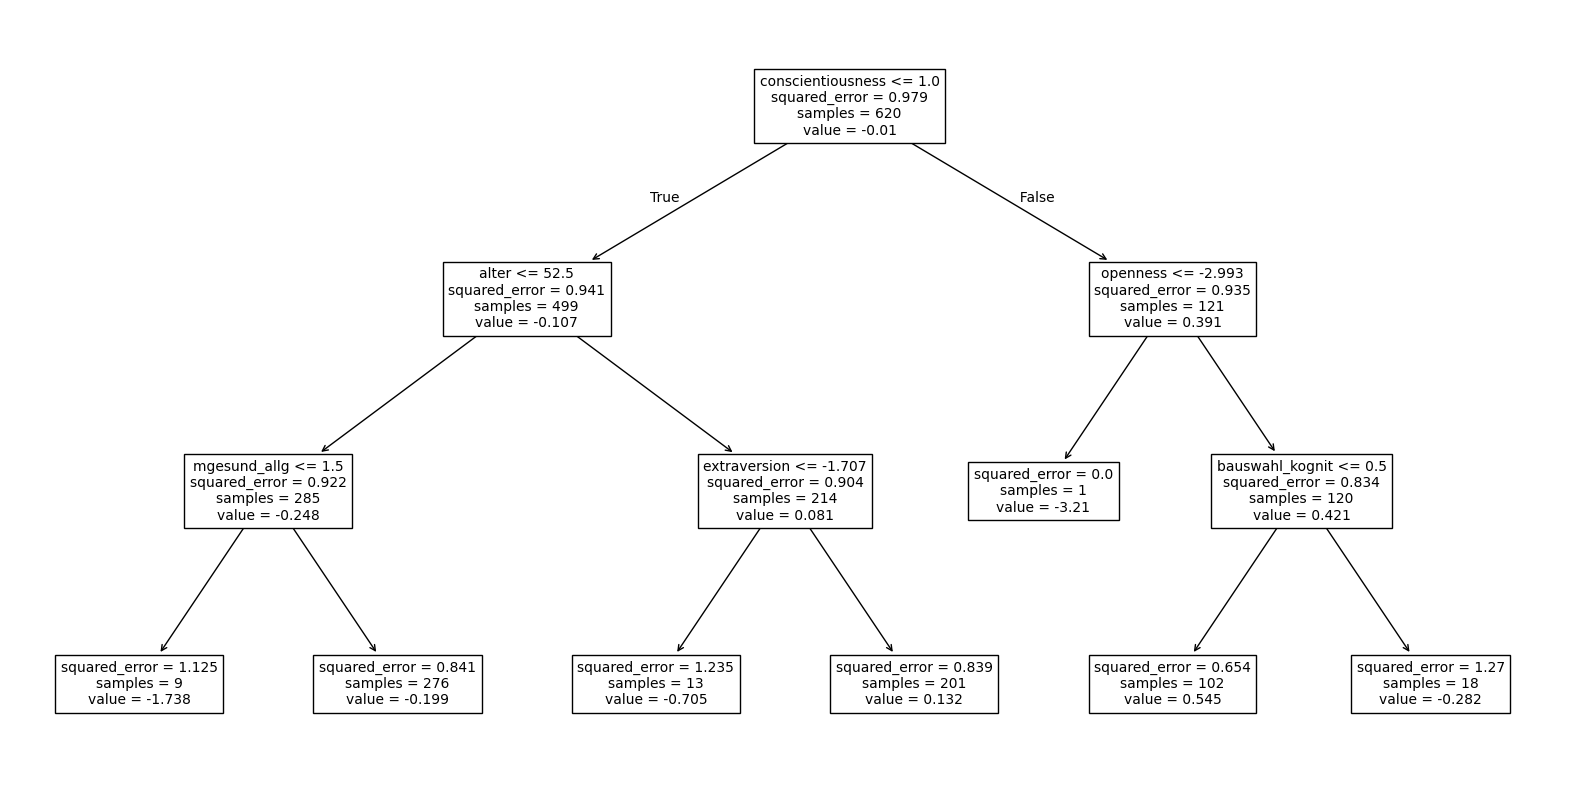

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(dtree, feature_names=X.columns, fontsize=10)
plt.show()

**Interpretation**
- The tree gives us a visual representation of the data
- Here we allowed a depth of 3 such that we have up to 2³=8 leaves in the tree
- The plot of the tree here also shows the mean value of enga in each leaf. This gives the predicted value of enga for feature vectors that satisfy the path of yes/no conditions at each node up to that leaf.
- The "samples" stated in the leaf of the tree shows the number of observations in the leaf.

# **Train and Test R²**
----

- To avoid that our R² estimate is driven by overfitting we only use part of the sample to train the algorithm and check the MSE/R² on the remaining test sample.
- We use the train_test_split function from sklearn to make the split.
- Here we use 70% of the data for training and 30% for the test sample
- The function randomly determines which observation goes into the training and which goes into the test sample
- When we set a specific random state we can assure that the random numbers are the same when you run the code again


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=156)

dtree= DecisionTreeRegressor(max_depth=3).fit(X_train,y_train)

print("R²_train=", round(r2_score(y_train, dtree.predict(X_train)),2))
print("R²_test=",  round(r2_score(y_test, dtree.predict(X_test)),2))

R²_train= 0.15
R²_test= 0.04


**Interpretation**

- While the training R² is similar to the R² in the whole sample (here actually by chance a bit larger), the test R² is much smaller
- Hence, the prediction accuracy is much smaller than a simple in-sample estimate would show.

In [ ]:
for d in range(1,6):
  dtree= DecisionTreeRegressor(max_depth=d).fit(X_train,y_train)
  print("Depth ", d)
  print("Train R²:", round(r2_score(y_train, dtree.predict(X_train)),3))
  print("Test R²:", round(r2_score(y_test, dtree.predict(X_test)),3))
  print("")

Depth  1
Train R²: 0.04
Test R²: 0.019

Depth  2
Train R²: 0.083
Test R²: 0.036

Depth  3
Train R²: 0.148
Test R²: 0.037

Depth  4
Train R²: 0.225
Test R²: 0.01

Depth  5
Train R²: 0.304
Test R²: -0.067



**Interpretation**

- Here we compare the test R² between trees of different depths (I here do in a loop, but you can of course just copy the code and vary max_depth).
- We see that the test R² first increases but already for a depth of 4 falls and even becomes negative for a depth of 5.
- This is due to overfitting: the deeper tree picked up patterns which are just due to the sampling.
- A more shallow tree exhibits thus a lower variance (even though it comes with more bias)

# **Random Forests**
----

We here train a random forest, an ensemble of many trees (here 500)
- The RandomForestRegressor class performs all the heavy lifting (using bootsrap aggregation - i.e. drawing different bootstrap samples for each tree - and randomly choosing the subset of features that each tree can choose from at each node for splitting the data)
- Here we use the square root of the number of all features


In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=500, max_features='sqrt', random_state=181).fit(X_train, y_train)

print("Test R²:", round(r2_score(y_test, forest.predict(X_test)),3))


Test R²: 0.089


A Random Forest gives us a substantially better prediction that a single tree. The low prediction quality of a single tree is due to the problem that a shallow tree exhibits a large bias (it cannot account for complex patterns in the data) and a deep tree leads to overfitting.
Moreover, splits made in the lower part of a tree can use less and less data and, in turn, learning about the role of feautures that do not show up at the top of the tree is more difficult and overfitting more likely (note that for instance a further split on the fourth level of a tree can only use 1/8 of the data).  
The random forest reduces these problems. The randomness introduced through bagging and by restricting splits to randomly chosen subset of the features allows the forest to learn also where it is more difficult to learn. Each single tree has a lot of variance but the aggregation (computing the average prediction across the trees) reduces this variance.   